# Progetto architettura dati

Si vuoule leggere un dataset di applicazioni android, ogni aplicazione è etichettata come "goodware" o "malware" e le feature del dataset sono i permessi richiesti nel manifest dell'applicazione / alcune api call fatte dall'app.

Si vogliono sviluppare i seguenti 2 punti:
1. dimostrare che è possibile predirre correttamente se un applicazione è un malware o goodware in base ai permessi e le api call

In [1]:
# import delle librerie necessarie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# logistic regression model
from sklearn.linear_model import LogisticRegression

# RFECV
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV

# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer


## Caricare il dataset

Si parte da un dataset con le seguenti feature:
- colonna 1->214: Permission-based features -> sono tutte feature binarie 0=permesso non richiesto, 1=permesso richiesto
- colonna 215->241: API based features -> sono tutte feature binarie 0=api call non richiesta, 1=api call richiesta
- colonna 242: label (target), dove le classi sono:
    - Malware 
    - Goodware

In [2]:
# Lettura del dataset
dataset = pd.read_csv('Dataset/TUANDROMD.csv')

In [3]:
# Mi salvo target e features in variabili diverse
uni_target = dataset[['Label']]
uni_feature = dataset.drop(['Label'], axis=1)

print(uni_target)

         Label
0      malware
1      malware
2      malware
3      malware
4      malware
...        ...
4460  goodware
4461  goodware
4462  goodware
4463  goodware
4464  goodware

[4465 rows x 1 columns]


## Data Exploration
Come primo step controlliamo la numerosità del dataset.

In [4]:
# Mi salvo in una variabile il numero di features per dopo
n_features0 = dataset.shape[1] - 1

# Stampo il numero di records e di features
print(f'Ci sono {dataset.shape[0]} istanze ed un totale di {n_features0} features!')

Ci sono 4465 istanze ed un totale di 241 features!


### Dataset sbilanciato?

Il dataset è sbilanciato? proviamo a fare un **analisi univariata** sui valori di Label per verificare:

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

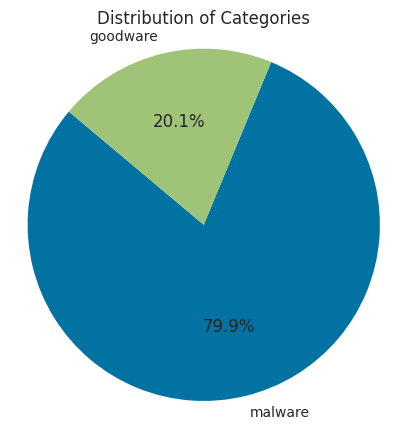

In [5]:
# Conta le occorrenze per ogni valore di Label
label_counts = uni_target['Label'].value_counts()

# Visualizzali in un piechart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')
plt.show()

Per quanto possa non piacerci molto la notizia che il dataset sia sbilanciato (può comportare degli errori bias nella classificazione dei modelli) abbiamo però la buona notizia della sicurezza che il data-set sia binario. 

Sarà quindi necessario utilizzare modelli che offrono buone prestazioni su dataset binari e non troppo suscettibili a dataset sbilanciati. Inoltre **poiché questo set di dati è fortemente sbilanciato, non dobbiamo utilizzare l'accuratezza come parametro di valutazione**, sarebbe meglio invece usare l'F1-score

### Valori mancanti?
Controlliamo ora se il dataset contiene valori mancanti

In [6]:
null_count_features = np.count_nonzero(uni_feature.isna().sum())
print(f"in totale ci sono {null_count_features}/241 features con valori mancanti")

in totale ci sono 241/241 features con valori mancanti


sembra che **tutte** le features contengano almeno un valore nullo.

sviluppiamo quindi una funzione che ci andrà ad elencare tutte le features con valori mancanti in ordine decrescente:

In [7]:
def conteggio_valori_nulli_per_colonna(df):
    colonne_con_valori_nulli = df.columns[df.isnull().any()]
    conteggio_valori_nulli = [(colonna, df[colonna].isnull().sum()) for colonna in colonne_con_valori_nulli]
    conteggio_valori_nulli_sorted = sorted(conteggio_valori_nulli, key=lambda x: x[1], reverse=True)
    
    for colonna, num_valori_nulli in conteggio_valori_nulli_sorted:
        print(f"Colonna '{colonna}': {num_valori_nulli} valori nulli")
        if num_valori_nulli > 0:
            print("Record con valori nulli:")
            records_con_null = df[df[colonna].isnull()]
            for index, row in records_con_null.iterrows():
                print(f"Indice: {index}, Valori: {row.to_dict()}")

In [8]:
print(conteggio_valori_nulli_per_colonna(dataset))

Colonna 'ACCESS_ALL_DOWNLOADS': 1 valori nulli
Record con valori nulli:
Indice: 2533, Valori: {'ACCESS_ALL_DOWNLOADS': nan, 'ACCESS_CACHE_FILESYSTEM': nan, 'ACCESS_CHECKIN_PROPERTIES': nan, 'ACCESS_COARSE_LOCATION': nan, 'ACCESS_COARSE_UPDATES': nan, 'ACCESS_FINE_LOCATION': nan, 'ACCESS_LOCATION_EXTRA_COMMANDS': nan, 'ACCESS_MOCK_LOCATION': nan, 'ACCESS_MTK_MMHW': nan, 'ACCESS_NETWORK_STATE': nan, 'ACCESS_PROVIDER': nan, 'ACCESS_SERVICE': nan, 'ACCESS_SHARED_DATA': nan, 'ACCESS_SUPERUSER': nan, 'ACCESS_SURFACE_FLINGER': nan, 'ACCESS_WIFI_STATE': nan, 'activityCalled': nan, 'ACTIVITY_RECOGNITION': nan, 'ACCOUNT_MANAGER': nan, 'ADD_VOICEMAIL': nan, 'ANT': nan, 'ANT_ADMIN': nan, 'AUTHENTICATE_ACCOUNTS': nan, 'AUTORUN_MANAGER_LICENSE_MANAGER': nan, 'AUTORUN_MANAGER_LICENSE_SERVICE(.autorun)': nan, 'BATTERY_STATS': nan, 'BILLING': nan, 'BIND_ACCESSIBILITY_SERVICE': nan, 'BIND_APPWIDGET': nan, 'BIND_CARRIER_MESSAGING_SERVICE': nan, 'BIND_DEVICE_ADMIN': nan, 'BIND_DREAM_SERVICE': nan, 'BIND_G

Ma in seguito ad un analisi più approfondita (tramite il richiamo della funzione appena definita) ci accorgiamo che è solo la riga 2533 ad avere valori nulli, possiamo dunque eliminarla dal dataset (in quanto non fornisce nessun valore infromativo, tutte le sue feature sono nulle)

In [9]:
# Visto che abbiamo appurato che solo la riga 2533 contiene valori nulli possiamo droppare "tutte" le righe con valori nulli
# mettiamo poi a paragone con il dorppare solo la riga 2533
# se questa operazione torna true abbiamo ulteriore conferma che solo la riga 2533 conteneva valori nulli
print ( dataset.dropna().equals( dataset.drop(2533)) )

True


Dato che l'operazione ritorna true allora possiamo definitivamente eliminare la riga dal dataset e ri-inizializzare le variabili di:
- dataset
- features
- target

In [10]:
dataset = dataset.dropna()
uni_target = dataset[['Label']]
uni_feature = dataset.drop(['Label'], axis=1)

## Preparazione dei dati

Prima di creare test e train set di decide di fare una fase di preparazione dei dati. 

Si è già dimostrato che per quanto sbilanciato il dataset è molto pulito, quindi non ci sarà bisogno di svolgere molti passaggi in questa sezione

### Analisi bivariata della correlazione - Eliminazione feature ridondanti

Il coefficiente di correlazione ha valori compresi tra -1 e 1
- Un valore più vicino allo 0 implica una correlazione più debole (0 esatto implica nessuna correlazione)
- Un valore più vicino a 1 implica una correlazione positiva più forte
- Un valore più vicino a -1 implica una correlazione negativa più forte

Se due features indipendenti (indipendenti = non target) hanno una correlazione assoluta elevata, le informazioni che offrono per il nostro modello ML sono sostanzialmente le stesse.

Le funzionalità correlate in generale non migliorano i modelli, quindi se ne può eliminarne una, in quanto è ridondante. Con la seguente funzione possiamo selezionare fature altamente correlate (correlate ad un altra feature al 95%)

In [11]:
# nota: la funzione rimuoverà la PRIMA feature correlata a qualsiasi altra feature
def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # siamo interessati al valore assoluto del coeff
                colname = corr_matrix.columns[i]  # si prende la stringa del nome della colonna
                col_corr.add(colname)
    return col_corr

In [12]:
non_correlated_features = correlation(uni_feature, 0.95) #da qui si imposta che voglio threshold di correlazione minimo 95%

# Inizializzo variabile delle feature meno importanti
less_important_features = non_correlated_features

# Inizializzazione varibile feature più importanti
most_important_features = uni_feature.drop(non_correlated_features, axis=1)
n_correlated_features = most_important_features.shape[1]

print(f'Dopo aver droppato {len(non_correlated_features)} features, rimangono {n_correlated_features} features.')
print("Features droppate:")
print(non_correlated_features)

After removing 80 features, there are 161 features left.
Dropped features:
{'BROADCAST_SMS', 'UNINSTALL_SHORTCUT', 'MANAGE_DOCUMENTS', 'CAPTURE_VIDEO_OUTPUT', 'SET_ALWAYS_FINISH', 'WRITE_USER_DICTIONARY', 'RECEIVE_WAP_PUSH', 'INSTALL_SHORTCUT', 'MEDIA_CONTENT_CONTROL', 'RECEIVE_MMS', 'STATUS_BAR', 'SET_ALARM', 'SET_PROCESS_LIMIT', 'BLUETOOTH_PRIVILEGED', 'GLOBAL_SEARCH', 'READ_HISTORY_BOOKMARKS', 'BROADCAST_PACKAGE_REMOVED', 'MANAGE_APP_TOKENS', 'INJECT_EVENTS', 'SET_ACTIVITY_WATCHER', 'ADD_VOICEMAIL', 'SET_POINTER_SPEED', 'READ_USER_DICTIONARY', 'CONTROL_LOCATION_UPDATES', 'BIND_DREAM_SERVICE', 'BIND_VPN_SERVICE', 'ACCESS_SURFACE_FLINGER', 'USE_SIP', 'SET_DEBUG_APP', 'SET_PREFERRED_APPLICATIONS', 'GET_TOP_ACTIVITY_INFO', 'BIND_APPWIDGET', 'Ljava/lang/System;->loadLibrary', 'WRITE_PROFILE', 'READ_INPUT_STATE', 'CAPTURE_AUDIO_OUTPUT', 'INTERNAL_SYSTEM_WINDOW', 'READ_FRAME_BUFFER', 'MOUNT_FORMAT_FILESYSTEMS', 'SET_ORIENTATION', 'BROADCAST_WAP_PUSH', 'SUBSCRIBED_FEEDS_WRITE', 'CALL_PRIVIL

### Analisi bivariata della correlazione - Highlight delle feature più importanti

A differenza della correlazione a coppie vista prima, in cui è desiderabile una correlazione inferiore, vorremmo che le nostre features avessero un'elevata correlazione con il target. Se una feature ha una bassa correlazione con il target, significa che non è una funzionalità utile per prevedere il target e, pertanto, dovrebbe essere rimossa. 

La seguente funzione calcolerà la correlazione di ciascuna caratteristica con il target e poi restituirà le colonne che hanno una correlazione inferiore alla soglia scelta.

In [13]:
def corrwith_target(dataframe, target, threshold):
    cor = dataframe.corr()
    # Calcolo Correlazione con il target
    cor_target = abs(cor[target])
    # Seleziona le features non correlate
    relevant_features = cor_target[cor_target<threshold]
    return relevant_features.index.tolist()[:-1]

In [14]:
# Si deve creare una variabile di dataset dummy (che contiene anche il target) per far girare il metodo appena creato
uni_target_dummy = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])
dummy_dataset = uni_feature.copy()
dummy_dataset['Label'] = uni_target_dummy

/tmp/ipykernel_261749/2363470553.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uni_target_dummy = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])


In [15]:
corrwith_cols = corrwith_target(dummy_dataset, 'Label', 0.05)

# Aggiunta delle feature meno importanti ritrovate a questo passaggio
less_important_features.update( corrwith_cols )

# Aggiornamento delle feature più importanti 
# (si droppano quelle meno importanti appena trovate da quelle most_important trovate precedentemente)
# Crea un set di nomi delle colonne più importanti
most_important_features_columns = set(most_important_features.columns)
# Trova l'intersezione tra most_important_features - corrwith_cols
common_columns = most_important_features_columns.intersection(corrwith_cols)
# Droppa le colonne da most_important_features se ce ne sono
if common_columns:
    most_important_features.drop(columns=common_columns, inplace=True)

n_correlated_features = most_important_features.shape[1]

print(f'Dopo aver droppato in totale {len(less_important_features)} features, rimangono {n_correlated_features} features.')
print("Colonne droppate in questa operazione:")
print(corrwith_cols)

After removing a total of 128 features, there are 113 features left.
Currently dropped columns:
['ACCESS_CHECKIN_PROPERTIES', 'ACCESS_COARSE_UPDATES', 'ACCESS_LOCATION_EXTRA_COMMANDS', 'ACCESS_MOCK_LOCATION', 'ACCESS_MTK_MMHW', 'ACCESS_SUPERUSER', 'ACCESS_SURFACE_FLINGER', 'ACCOUNT_MANAGER', 'BILLING', 'BIND_ACCESSIBILITY_SERVICE', 'BIND_APPWIDGET', 'BIND_CARRIER_MESSAGING_SERVICE', 'BIND_DREAM_SERVICE', 'BIND_INPUT_METHOD', 'BIND_NFC_SERVICE', 'BIND_goodwareTIFICATION_LISTENER_SERVICE', 'BIND_PRINT_SERVICE', 'BIND_REMOTEVIEWS', 'BIND_TEXT_SERVICE', 'BIND_TV_INPUT', 'BIND_VOICE_INTERACTION', 'BIND_VPN_SERVICE', 'BIND_WALLPAPER', 'BLUETOOTH_PRIVILEGED', 'BODY_SENSORS', 'BRICK', 'BROADCAST_PACKAGE_REMOVED', 'BROADCAST_SMS', 'BROADCAST_STICKY', 'BROADCAST_WAP_PUSH', 'C2D_MESSAGE', 'CALL_PHONE', 'CALL_PRIVILEGED', 'CAPTURE_AUDIO_OUTPUT', 'CAPTURE_SECURE_VIDEO_OUTPUT', 'CAPTURE_VIDEO_OUTPUT', 'CHANGE_COMPONENT_ENABLED_STATE', 'CHANGE_CONFIGURATION', 'CHANGE_WIFI_MULTICAST_STATE', 'CLEAR_APP

### Calcolo PCA (Recursive feature elimination)

So che è una cosa buona e che rimuove le features ma non so bene come funziona

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(uni_feature)

scaled_data

# Visualize the data
mcc_scorer = make_scorer(matthews_corrcoef)
rfecv = RFECV(estimator=LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),
              cv=StratifiedKFold(2),
              scoring =  mcc_scorer)
rfecv.fit(uni_feature, uni_target.values.ravel())
rfecv.show() 

## Creazione di Test e Train set

In [ ]:
#prima sostituisco nel target dei valori numerici 0 ed 1 alle stringhe "goodware" e "malware"
uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])
print(uni_target)

X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

      Label
0         0
1         0
2         0
3         0
4         0
...     ...
4460      1
4461      1
4462      1
4463      1
4464      1

[4464 rows x 1 columns]


/tmp/ipykernel_147274/2910749984.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])


In [ ]:
y_train = y_train.replace(to_replace=["goodware", "malware"], value=[1, 0])
y_test = y_test.replace(to_replace=["goodware", "malware"], value=[1, 0])